## Basic Pipeline for image processing of our CNN 

### Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os

In [2]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.math import confusion_matrix

In [3]:
import tensorflow as tf 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical

In [4]:
from sklearn.model_selection import train_test_split

### Import for large model with csv

#### Create Dataframe of Data 

In [ ]:
directory_no_mask = '../raw_data/Dataset/without_mask/'

no_mask_names = os.listdir(directory_no_mask)

no_mask_df = pd.DataFrame()
no_mask_df['file_name'] = no_mask_names
no_mask_df['file_name'] = directory_no_mask + no_mask_df['file_name']
no_mask_df['label'] = 0

In [ ]:
no_mask_df.shape

In [ ]:
directory_wrong_mask = '../raw_data/Dataset/mask_weared_incorrect/'

wrong_mask_names = os.listdir(directory_wrong_mask)

wrong_mask_df = pd.DataFrame()
wrong_mask_df['file_name'] = wrong_mask_names
wrong_mask_df['file_name'] = directory_wrong_mask + wrong_mask_df['file_name']
wrong_mask_df['label'] = 1

In [ ]:
wrong_mask_df.shape

In [ ]:
directory_with_mask = '../raw_data/Dataset/with_mask/'

with_mask_names = os.listdir(directory_with_mask)

with_mask_df = pd.DataFrame()
with_mask_df['file_name'] = with_mask_names
with_mask_df['file_name'] = directory_with_mask + with_mask_df['file_name']
with_mask_df['label'] = 2

In [ ]:
with_mask_df.shape

In [ ]:
df = pd.concat([no_mask_df,wrong_mask_df,with_mask_df])

In [ ]:
df.shape

In [ ]:
df.head()

#### Create Train, Test, Val Set 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0], df.iloc[:,1:], test_size=0.20, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [ ]:
def read_img(image_file, label):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_image(image, channels = 3, dtype = tf.float32)
    image = tf.image.resize_with_pad(image, 224, 224)
     #image = image / 255.
    return image, label 

In [ ]:
y_cat_train = to_categorical(y_train, num_classes=3)
y_cat_val = to_categorical(y_val, num_classes=3)
y_cat_test = to_categorical(y_test, num_classes=3)
y_cat_train.shape

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train.values , y_cat_train))
ds_train = ds_train.map(read_img).batch(32)

In [ ]:
ds_val = tf.data.Dataset.from_tensor_slices((X_val.values, y_cat_val))
ds_val = ds_val.map(read_img).batch(32)

In [ ]:
ds_test = tf.data.Dataset.from_tensor_slices((X_test.values, y_cat_test))
ds_test = ds_test.map(read_img).batch(32)

### Agumentation for Images (Just in Case)

### Scale the Images

In [ ]:
# not necessary with the current image import
#X.scaled = X / 255

### Built a basic CNN just like in class

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(6, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=(224, 224, 3)))
model.add(layers.Conv2D(4, kernel_size=(3), padding='valid', activation='relu')) # kernel_size = 3 <==> (3, 3)
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax')) 

model.summary() 

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
history =model.fit(ds_train, epochs = 10, validation_data = ds_val, callbacks = [es])

In [ ]:
model.evaluate(ds_test, verbose=0)

In [ ]:
save_path = ('../models')
model.save(save_path)

In [ ]:
save_path = ('../models')
model = tf.keras.models.load_model(save_path)

In [ ]:
model.summary()

### Transfer learning with a suitable network

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

#### MobileNetV2

In [ ]:
base_model_1 = MobileNetV2(weights="imagenet", include_top=False,input_shape = (224,224,3)) 
base_model_1.trainable = False


In [ ]:
pooling = layers.MaxPool2D(pool_size=(2,2))
flatten_layer = layers.Flatten()
dense_1 = layers.Dense(128, activation="relu")
drop_1 = layers.Dropout(0.3)
prediction_1 = layers.Dense(3, activation="softmax")

In [ ]:
model1 = models.Sequential([
    base_model_1,
    pooling, 
    flatten_layer,
    dense_1,
    drop_1,
    prediction_1
])

In [ ]:
model1.summary()

In [ ]:
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
history_1 = model1.fit(ds_train, epochs = 10, validation_data = ds_val, callbacks = [es])

In [ ]:
model1.evaluate(ds_test)

In [ ]:
save_path = ('../models/Model_1')
model1.save(save_path)

In [ ]:
save_path = ('../models/model_1.1')
model1 = tf.keras.models.load_model(save_path)

In [ ]:
# Fit the model
# list all data in history
# summarize history for accuracy
plt.title("Training Loss and Accuracy")
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

In [ ]:
prediction_proba_m1 = model1.predict(ds_test)

In [ ]:
prediction_m1 = prediction_proba_m1.argmax(axis = 1)

In [ ]:
print(confusion_matrix(y_test, prediction_m1))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, prediction_m1))

#### NASNetMobile

In [ ]:
from tensorflow.keras.applications import NASNetMobile

In [ ]:
base_model_2 = NASNetMobile(
    input_shape= None,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,)
base_model_2.trainable = False
base_model.summary()

In [ ]:
dense_layer = layers.Dense(500, activation = 'relu')
prediction_layer = layers.Dense(3, activation = 'softmax')

model2 = models.Sequential([
    base_model_2, 
    prediction_layer
])

In [ ]:
model2.summary()

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model2.fit(ds_train, epochs = 10, validation_data = ds_val, callbacks = [es])

In [ ]:
model2.evaluate(ds_test)

In [ ]:
[0.5263108015060425, 0.5971062779426575]

In [ ]:
prediction_m2 = model2.predict(ds_test)

In [ ]:
confusion_matrix(y_test, prediction_m2)

### Face recognition

In [5]:
import tensorflow as tf
import cv2
import mtcnn
import os
from PIL import Image

In [6]:
def load_picture(path_to_file):
    img = tf.io.read_file(path_to_file)
    img = tf.image.decode_image(img, channels = 3, dtype = tf.float32)
    img = img.numpy()
    return img
    

In [7]:
detector = mtcnn.MTCNN(steps_threshold=[0.7, 0.7, 0.7])
def detect_faces(img):
    faces= detector.detect_faces(img*255)
    return faces

2021-09-09 19:01:15.467345: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def face_from_coordinates(img,x,y,w,h):
    return img[y:y+h,x:x+w]

In [9]:
def face_cropping(faces, img):
    encoded_faces = []
    for index, face in enumerate(faces):
        encoded_faces.append(face_from_coordinates(img, *face['box']))
    return encoded_faces

In [10]:
def face_cropping(faces, img):
    encoded_faces = []
    for face in faces:
        encoded_faces.append(face_from_coordinates(img, *face['box']))
    return encoded_faces

In [11]:
def prep_prediction_multi(encoded_face):
    img = tf.image.resize_with_pad(encoded_face, 224, 224)
    img= tf.expand_dims(img,0)
    return img

In [12]:
def prep_prediction_one(encoded_face):
    img = tf.image.resize_with_pad(encoded_face, 224, 224)
    #img= tf.expand_dims(img,0)
    return img

Funktion for face probability prediction 

In [13]:
def pred_mask(faces, img):
    cropped_face= face_cropping(faces, img)
    if len(cropped_face) == 1: 
        face = prep_prediction_one(cropped_face)
        return [model.predict(face).argmax()]
    elif len(cropped_face) > 1: 
        faces = []
        for j in range(len(cropped_face)):
            face = prep_prediction_multi(cropped_face[j])
            faces.append(face)
        predictions = []
        for face in faces:
            predictions.append(model.predict(face).argmax())
        return predictions
    else:
        return [3]
            

In [14]:
def draw_image(image, coordinates, prediction):
    color_corresp = {
      0: (255,0,0),
      1: (255,165,0),
      2: (0,255,0)}
    coordinates =[faces[i]['box'] for i in range(len(faces))]
    for i in range(len(coordinates)):
        cv2.rectangle(image,
                      (coordinates[i][0],coordinates[i][1]),
                      (coordinates[i][0]+coordinates[i][2],coordinates[i][1]+ coordinates[i][3]),
                      color_corresp[prediction[i]],3)
    plt.imshow(image)                
                   


In [15]:
save_path = ('../models/Model_1')
model = tf.keras.models.load_model(save_path)

In [ ]:
# load image from file
#filename = '../raw_data/face_no_mask/no_mask_marga.jpg'
filename = '../raw_data/face_with_mask/mask_marga_1.jpg'
#filename = '../raw_data/archive/images/maksssksksss4.png'
#filename = '../raw_data/Face_with_mask/Augmented_56_323581.png'


In [ ]:
face_cropping(faces, img)

2021-09-09 19:01:28.391432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0]


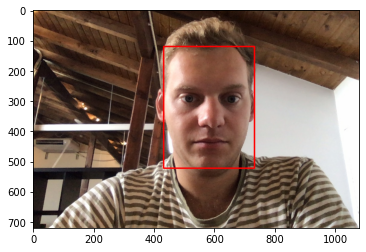

In [16]:
filename = '../raw_data/face_no_mask/marc_no_mask.jpg'
img = load_picture(filename)
faces = detect_faces(img)
prediction = pred_mask(faces, img)
print(prediction)
draw_image(img, faces, prediction)

#### Create dataset of images to predict

In [ ]:
#creating a test set of pictures with mask and without mask

path_mask = '../raw_data/Face_Mask_Dataset/Test/WithMask'
path_no_mask = '../raw_data/Face_Mask_Dataset/Test/WithoutMask'

#path_mask = '../raw_data/Face_with_mask'
#path_no_mask = '../raw_data/Face_no_Mask'

list_mask = os.listdir(path_mask)
list_mask.sort()


list_no_mask = os.listdir(path_no_mask)
list_no_mask.sort()

X_model_test = []
y_model_test = []

for i in range(150,400):
        c_path = os.path.join(path_mask, list_mask[i])
        X_model_test.append(plt.imread(c_path)[:, :, :])
        y_model_test.append(2) 
    

for i in range(150,400):
        c_path = os.path.join(path_no_mask, list_no_mask[i])
        X_model_test.append(plt.imread(c_path)[:, :, :])
        y_model_test.append(0) 

In [ ]:
# detecting faces in each picture -- only one face per picture is correct
faces_list = []
for image in X_model_test:
    faces = detect_faces(image)
    faces_list.append(faces)
    
    

In [ ]:
# sort all the pictures in which no face was detected 

faces_array = np.array(faces_list)
faces_array = faces_array[[el != [] for el in faces_list]]

X_model_test_array = np.array(X_model_test)
X_model_test_array = X_model_test_array[[el != [] for el in faces_list]]

y_model_test_array = np.array(y_model_test)
y_model_test_array=y_model_test_array[[el != [] for el in faces_list]]

number_of_detected_faces = len([el for el in faces_list if el != [] ])
number_of_missed_faces = len([el for el in faces_list if el == [] ])

In [ ]:
number_of_missed_faces

In [ ]:
#predict wearing a mask or not 
predictions = []
for faces , img in zip(faces_array,X_model_test_array):
    predictions.append(pred_mask(faces, img))

In [ ]:
#Show Pictures of more than one face
for index, el in enumerate(predictions):
    if len(el) > 1:
        print(index)
    

In [ ]:
# create an np array to pass in the confusion matrix
pred_2 = []
for el in predictions:
    for e in el:
        pred_2.append(e)
pred_2 = np.array(pred_2)

In [ ]:
#create the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_model_test_array, pred_2))

In [ ]:
np.unique(pred_2)

In [ ]:
np.array(y_model_test)

### Blaze faze static 

In [ ]:
import cv2
import mediapipe as mp
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
# For static images:
IMAGE_FILES = ['../raw_data/face_no_mask/marc_no_mask.jpg']
with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
    for idx, file in enumerate(IMAGE_FILES):
            image = cv2.imread(file)
            # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
            results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            # Draw face detections of each face.
            if not results.detections:
                  continue
            annotated_image = image.copy()
            for detection in results.detections:
                print('Nose tip:')
                print(mp_face_detection.get_key_point(
                    detection, mp_face_detection.FaceKeyPoint.NOSE_TIP))
                mp_drawing.draw_detection(annotated_image, detection)
    cv2.imwrite('/frames/' + str(idx) + '.png', annotated_image)


In [17]:
import cv2
import mediapipe as mp
img = tf.io.read_file('../raw_data/face_no_mask/marc_no_mask.jpg')
img = tf.image.decode_image(img, channels = 3, dtype = tf.uint8)

In [18]:
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection= mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
image = cv2.imread('../raw_data/face_no_mask/marc_no_mask.jpg')
image_shape = image.shape

In [21]:
results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [22]:
results.detections

[label_id: 0
 score: 0.8785384893417358
 location_data {
   format: RELATIVE_BOUNDING_BOX
   relative_bounding_box {
     xmin: 0.3866904377937317
     ymin: 0.2587711811065674
     width: 0.31570011377334595
     height: 0.47353625297546387
   }
   relative_keypoints {
     x: 0.4837181270122528
     y: 0.4166017770767212
   }
   relative_keypoints {
     x: 0.6050671935081482
     y: 0.4174325466156006
   }
   relative_keypoints {
     x: 0.5529894232749939
     y: 0.5316244959831238
   }
   relative_keypoints {
     x: 0.5497156381607056
     y: 0.6162384748458862
   }
   relative_keypoints {
     x: 0.40517452359199524
     y: 0.45672130584716797
   }
   relative_keypoints {
     x: 0.6559516191482544
     y: 0.45634883642196655
   }
 }]

In [23]:
def converting_results_to_coordinates(results, image_shape):
    faces_coordinates = []
    if results.detections is not None:
        for detection in results.detections:
            box = detection.location_data.relative_bounding_box
            x1 = max(box.xmin * image_shape[1], 1)
            y1 = max(box.ymin * image_shape[0], 1)
            x2 = min(x1 + box.width * image_shape[1], image_shape[1])
            y2 = min(y1 + box.height * image_shape[0], image_shape[0])
            faces_coordinates.append([int(x1), int(y1), int(x2), int(y2)])
            print(faces_coordinates[-1])
    return faces_coordinates

#transforming coordinates of the face into a cropped image
def face_from_coordinates(image,x1,y1,x2,y2):
    return image[y1:y2, x1:x2]

def converting_faces_to_array(image, faces_coordinates):
    encoded_faces = []
    for face in faces_coordinates:
        encoded_faces.append(face_from_coordinates(image, *face))
        #save_img('/frames/',
    return encoded_faces
def pred_mask(encoded_faces):
    if len(encoded_faces) == 1:
        face = prep_prediction_one(encoded_faces)
        return [model.predict(face).argmax()]
    elif len(encoded_faces) > 1:
        faces = []
        for j in range(len(encoded_faces)):
            face = prep_prediction_multi(encoded_faces[j])
            faces.append(face)
        predictions = []
        for face in faces:
            predictions.append(model.predict(face).argmax())
        return predictions
    else:
        return [3]

In [24]:
faces_coordinates = converting_results_to_coordinates(results, image_shape)

encoded_faces = converting_faces_to_array(image, faces_coordinates)

[417, 186, 758, 527]


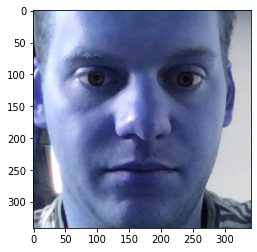

In [25]:
#image = cv2.cvtColor(encoded_faces[0], cv2.COLOR_RGB2BGR)
plt.imshow(encoded_faces[0])

In [ ]:
np.array(encoded_faces).shape

In [ ]:
np.array(image).shape

In [ ]:
image = prep_prediction_multi(image)

In [ ]:
plt.imshow(encoded_faces[0])

In [26]:
pred_mask(encoded_faces)

[2]